# Problema: Masa Resorte Amortiguador

In [ ]:
# Librerias utiles
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import imageio.v2 as imageio
from google.colab import drive
from google.colab import files
from os import TMP_MAX

# Modelo Físico

In [ ]:
# Parámetros físicos
l0 = 0.25 # m
g = 9.81  # m/s^2
m = 1     # kg
b = 0.5     # Ns/m
k = 2    # N/m
tiempo_total = 20 # s
delta_T = 0.01 # s
t_datos = 0.5*tiempo_total

In [ ]:
# Calculo de parámetros útiles
omega = np.sqrt(k/m)
seda  = b/(2*np.sqrt(m*k))
phi = np.arctan(-seda)
# Definir el vector de tiempo
t = np.arange(0, tiempo_total, delta_T)

print(f"omega = {omega}")
print(f"seda = {seda}")
print(f"phi = {phi}")


omega = 1.4142135623730951
seda = 0.17677669529663687
phi = -0.17496904566568885


In [ ]:
# Calcular desplazamiento y posición
def desplazamiento(tiempo):
  despl = (g / omega**2) * (1 - np.exp(-seda * omega * tiempo)* np.cos(omega * tiempo + phi)/np.cos(phi))
  return despl

u = desplazamiento(t)
x = u + l0


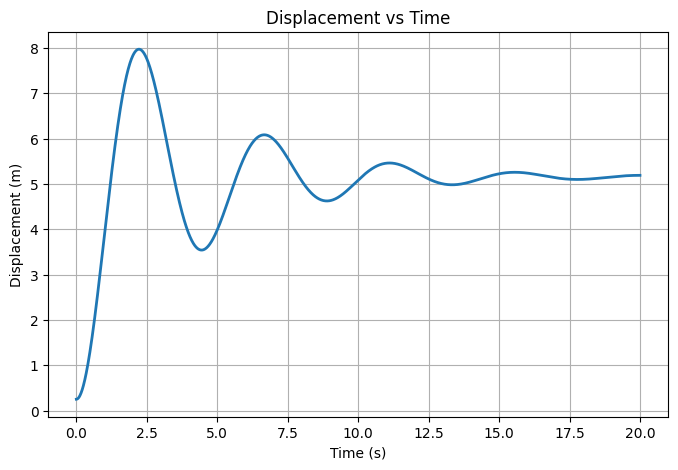

In [ ]:
# Graficar
plt.figure(figsize=(8, 5))
plt.plot(t, x, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.grid(True)
plt.title('Displacement vs Time')
plt.show()

# Parámetros para Modelos Predictivos

In [ ]:
# Crear datos de entrada para la red neuronal
# X es un vector de n valores seleccionados entre 0 y 10
n = 25 # Numero de muestras
t_max = t_datos # Tiempo maximo
t_min = 0 # Tiempo minimo
X = np.arange(t_min, t_max, (t_max-t_min)/n)
y = desplazamiento(X)
X_collocation = np.arange(0.0, tiempo_total, tiempo_total/100)
X_i = np.array([[0.0]])
b_init = np.array([[0.0]])

In [ ]:
# Convertir a tensores de PyTorch
X_train = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
X_test  = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
y_test  = torch.tensor(u, dtype=torch.float32).reshape(-1, 1)
X_train_phy = torch.tensor(X_collocation, dtype=torch.float32).reshape(-1, 1)
X_init = torch.tensor(X_i, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Parametros de la Red Neuronal
epochs_PINN_id =
learning_rate =
nneurons =
nhiden_layers =
activation_fn = nn.Tanh()
make_video = False

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])

# Modelo de Identificación - PINNs

## Clase Deep Neural Network 🧠

In [ ]:
class DNN(nn.Module):

  # Inicialización de la RED
  def __init__(self, layers):
    super(DNN, self).__init__() # Llama __init__ de la clase padre

    # Funcion de activacion
    self.activation_fn = activation_fn

    # Historial de loss
    self.loss_history = []

    # Definir capas (crea una lista de capas Fully connected)
    self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    # Inicializacion de pesos Xavier Glorot y bias como ceros
    for i in range(len(layers)-1):
      # Pesos
      nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.0)
      # Bias
      nn.init.zeros_(self.layers[i].bias.data)

  # Propagación hacia adelante
  def forward(self, x):
    for i in range(len(layers)-2):
      x = self.activation_fn(self.layers[i](x))

    x = self.layers[-1](x)
    return x

## Clase PINN_Id ⚛

In [ ]:
class PINN_id():
  def __init__(self,layers):

    # funcion de perdida
    self.loss_fn = nn.MSELoss(reduction = "mean")

    # Inicializando iterador
    self.iter = 0

    # Inicializando la DNN
    self.dnn = DNN(layers)

    self.b = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    self.b = nn.Parameter(self.b)
    self.dnn.register_parameter('b', self.b)
    self.parameter_history = {"b":[]}

    # Inicializando el historial de losses
    self.loss_history = {"Data":[],
                         "Physics":[],
                         "IC":[],
                         "Total":[],
                        }
  def loss_data(self, X, y):
    y_pred = self.dnn(X).reshape(-1,1)
    loss_data = self.loss_fn(y_pred, y)
    self.loss_history["Data"].append(loss_data.item())
    return loss_data

  def loss_physics(self, X_phy, X_init):
    # mg - k(x - l0) - b dx/dt - m ddx/ddt = 0
    # como la red toma X_phy (tiempo) y devuelve y_pred (desplazamiento)
    # Se tiene: x = y_pred + l0
    #           t = X_phy
    # Loss_phy = mg - k(y_pred) - b d(x)/d(X_phy) - m dd(x)/dd(X_phy)
    X_physics = X_phy.clone().requires_grad_(True)
    y_pred = self.dnn(X_physics).reshape(-1,1)
    u = y_pred
    du_dt = torch.autograd.grad(u, X_physics, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    ddu_ddt = torch.autograd.grad(du_dt, X_physics, torch.ones_like(du_dt), retain_graph=True, create_graph=True)[0]
    b_pred = self.b
    self.parameter_history["b"].append(b_pred.item())
    seda_pred = b_pred/(2*np.sqrt(m*k))
    loss_physics = torch.norm(ddu_ddt + 2*seda_pred*omega*du_dt + omega**2*u - g)
    self.loss_history["Physics"].append(loss_physics.item())

    # En el instante inicial:
    # u(0) = 0
    # du/dt(0) = 0
    # ddu/ddt(0) = g(1-seda_pred**2)
    X_initial = X_init.clone().requires_grad_(True)
    y_pred_init = self.dnn(X_initial).reshape(-1,1)
    u_init = y_pred_init
    du_dt_init = torch.autograd.grad(u_init, X_initial, torch.ones_like(u_init), retain_graph=True, create_graph=True)[0]
    ddu_ddt_init = torch.autograd.grad(du_dt_init, X_initial, torch.ones_like(du_dt_init), retain_graph=True, create_graph=True)[0]
    loss_IC_term_1 = torch.norm(u_init)
    loss_IC_term_2 = torch.norm(du_dt_init)
    loss_IC_term_3 = torch.norm(ddu_ddt_init - g*(1-seda_pred**2))
    loss_IC = loss_IC_term_1 + loss_IC_term_2 + loss_IC_term_3
    self.loss_history["IC"].append(loss_IC.item())

    return loss_physics, loss_IC

  def loss_total(self, X, y, X_phy, X_init):
    loss_data = self.loss_data(X, y)
    loss_physics, loss_IC = self.loss_physics(X_phy, X_init)
    loss_total = loss_data + loss_physics + loss_IC
    self.loss_history["Total"].append(loss_total.item())
    return loss_total, loss_data, loss_physics, loss_IC

## Instanciar modelo ⛏

In [ ]:
# Instanciar modelo, definir función de pérdida y optimizador
model_pinn_id = PINN_id(layers)
loss_fn = nn.MSELoss(reduction = "mean")
optimizer = optim.Adam(model_pinn_id.dnn.parameters(), lr=learning_rate)

## Entrenar 🦾

In [ ]:
# Entrenamiento del modelo

print('Training with ADAM')
for epoch in range(epochs_PINN_id):
  # Forward
  loss, loss_data, loss_physics, loss_IC = model_pinn_id.loss_total(X_train, y_train, X_train_phy, X_init)

  # Backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch) % 100 == 0:
    print(f'Epoch [{epoch}/{epochs_PINN_id}], Loss_T: {loss.item():.6f}, Loss_data: {loss_data.item():.6f}, Loss_physics: {loss_physics.item():.6f}, Loss_IC: {loss_IC.item():.6f}, b_pred (real): {model_pinn_id.b.item():.3f}({b:.3f})')

    if make_video:
      # Haciendo plots para video
      y_pred = model_pinn_id(X_test).detach().numpy()
      plt.figure(figsize=(8, 5))
      plt.plot(X_test[:, 0].numpy(), y_test.numpy(), label='Real', linewidth=1.5)
      plt.plot(X_test[:, 0].numpy(), y_pred, label='Predicho', linewidth=1.5, linestyle='dashed')
      # plot los puntos de evaluacion con X
      plt.scatter(X[:, 0], y, color='red', label='Puntos de evaluación', marker= 'x')
      plt.xlabel('Time (seda)')
      plt.ylabel('Displacement (m)')
      plt.legend()
      plt.title(f"Epoch {epoch}")
      plt.savefig(f"frame_{epoch}.png")
      plt.close()
      frames.append(imageio.imread(f"frame_{epoch}.png"))

if make_video:
  # Guardar el GIF
  gif_path = "/content/training_animation.gif"
  imageio.mimsave(gif_path, frames, duration=0.5)
  files.download(gif_path)


Training with ADAM
Epoch [0/100000], Loss_T: 130.015762, Loss_data: 23.653105, Loss_physics: 96.444603, Loss_IC: 9.918052, b_pred (real): 0.000(0.500)
Epoch [100/100000], Loss_T: 35.081257, Loss_data: 1.993289, Loss_physics: 19.081306, Loss_IC: 14.006662, b_pred (real): 0.026(0.500)
Epoch [200/100000], Loss_T: 30.380272, Loss_data: 1.942245, Loss_physics: 13.756732, Loss_IC: 14.681293, b_pred (real): 0.047(0.500)
Epoch [300/100000], Loss_T: 22.548128, Loss_data: 2.489091, Loss_physics: 4.995684, Loss_IC: 15.063353, b_pred (real): 0.061(0.500)
Epoch [400/100000], Loss_T: 18.706001, Loss_data: 3.183043, Loss_physics: 0.405894, Loss_IC: 15.117065, b_pred (real): 0.066(0.500)
Epoch [500/100000], Loss_T: 18.441662, Loss_data: 3.187479, Loss_physics: 0.260733, Loss_IC: 14.993450, b_pred (real): 0.068(0.500)
Epoch [600/100000], Loss_T: 18.317017, Loss_data: 3.187488, Loss_physics: 0.207299, Loss_IC: 14.922230, b_pred (real): 0.069(0.500)


KeyboardInterrupt: 

## Evaluar resultados 📈

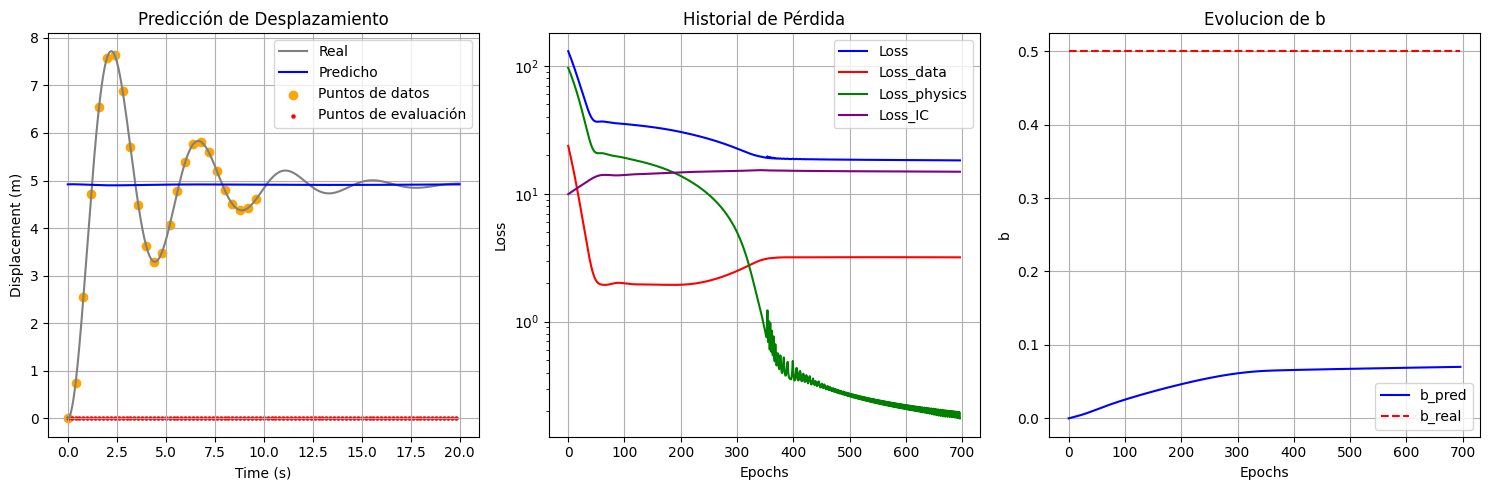

In [ ]:
# Hacer predicciones
y_pred = model_pinn_id.dnn(X_test).detach().numpy()

# Crear una figura con 3 subgráficos (1 fila, 3 columnas)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))



# --- Gráfico 1: Predicción vs Real ---
axs[0].plot(X_test, y_test, label='Real', linewidth=1.5, color = 'grey')
axs[0].plot(X_test, y_pred, label='Predicho', linewidth=1.5, color = 'blue')
axs[0].scatter(X_train, y_train, color='orange', label='Puntos de datos', marker='o')
axs[0].scatter(X_collocation, np.zeros_like(X_collocation), color='red', label='Puntos de evaluación', marker= 'o', s=5)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Displacement (m)')
axs[0].grid(True)
axs[0].set_title('Predicción de Desplazamiento')
axs[0].legend()

# --- Gráfico 2: Historial de pérdida ---
# plot y logaritmico
axs[1].semilogy(model_pinn_id.loss_history["Total"], label='Loss', color='blue', linewidth=1.5)
axs[1].semilogy(model_pinn_id.loss_history["Data"], label='Loss_data', color='red', linewidth=1.5)
axs[1].semilogy(model_pinn_id.loss_history["Physics"], label='Loss_physics', color='green', linewidth=1.5)
axs[1].semilogy(model_pinn_id.loss_history["IC"], label='Loss_IC', color='purple', linewidth=1.5)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].set_title('Historial de Pérdida')
axs[1].legend()


# --- Grafico 3: Evolucion de b
axs[2].plot(model_pinn_id.parameter_history["b"], label='b_pred', color='blue', linewidth=1.5)
# Grafica de b real
axs[2].plot(np.ones_like(model_pinn_id.parameter_history["b"])*b, label='b_real', color='red', linewidth=1.5, linestyle = "dashed")
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('b')
axs[2].grid(True)
axs[2].set_title('Evolucion de b')
axs[2].legend()


# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()